In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

# Load the data
df = pd.read_csv("/data/cephfs-1/work/groups/kühnen/users/cama15_c/meth_matrix_files/meth_matrix_10_samples.csv", sep=',')

In [2]:
# 1. Identify coverage columns (those ending with '_cov')
coverage_cols = [col for col in df.columns if col.endswith('_cov')]

# 2. Filter rows where coverage >= 10 in ALL samples (strict)
coverage_filter = df[coverage_cols].ge(10)  # True if coverage >= 10
rows_to_keep = coverage_filter.all(axis=1)  # Keep rows where all coverages >= 10

df_filtered = df.loc[rows_to_keep].copy()

print(f"Rows before filtering: {len(df)}")
print(f"Rows after coverage filtering: {len(df_filtered)}")

Rows before filtering: 28288934
Rows after coverage filtering: 17808826


In [3]:
# 3. Extract methylation fraction columns (those ending with '_frac')
frac_cols = [col for col in df_filtered.columns if col.endswith('_frac')]
frac_df = df_filtered[frac_cols]

# 4. Transpose so rows = samples, columns = features (CpG sites)
frac_df_t = frac_df.T

# 5. Clean sample names by removing '_frac'
frac_df_t.index = frac_df_t.index.str.replace('_frac', '')

# 6. Drop CpG sites (columns) with any missing data
frac_df_t_no_na = frac_df_t.dropna(axis=1)

print(f"Shape of PCA input matrix after dropping NaNs: {frac_df_t_no_na.shape}")

# Confirm shape: should be (number_of_samples, number_of_sites)

Shape of PCA input matrix after dropping NaNs: (10, 17808826)


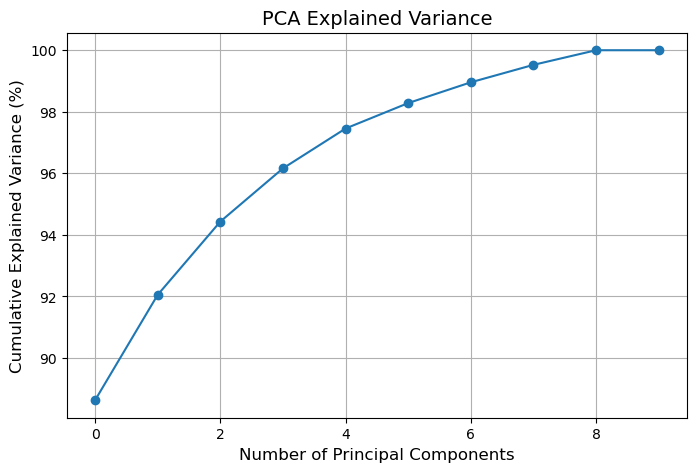

In [5]:
# 7. Run PCA
pca = PCA()
pca_result = pca.fit_transform(frac_df_t_no_na)

# 8. Explained variance ratio
explained_variance = pca.explained_variance_ratio_

plt.rcParams.update({ 
    'font.size': 12,           # default font size 
    'axes.titlesize': 14,      # subplot titles 
    'axes.labelsize': 12,      # x and y labels 
    'xtick.labelsize': 10,     # tick labels 
    'ytick.labelsize': 10, 
    'legend.fontsize': 11, 
    'figure.titlesize': 16     # suptitle 
})

# 9. Plot cumulative explained variance
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(explained_variance)*100, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.savefig("pca_explained_variance_10_samples.svg", format='svg', bbox_inches='tight')
plt.savefig("pca_explained_variance_10_samples.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [7]:
print(df.columns)

Index(['Chromosome', 'Start', 'End', 'Naive_1_frac', 'Naive_1_cov',
       'Formative_1_frac', 'Formative_1_cov', 'Primed_1_frac', 'Primed_1_cov',
       'Formative_Neuron_1_frac', 'Formative_Neuron_1_cov',
       'Primed_Neuron_1_frac', 'Primed_Neuron_1_cov', 'Naive_2_frac',
       'Naive_2_cov', 'Formative_2_frac', 'Formative_2_cov', 'Primed_2_frac',
       'Primed_2_cov', 'Formative_Neuron_2_frac', 'Formative_Neuron_2_cov',
       'Primed_Neuron_2_frac', 'Primed_Neuron_2_cov'],
      dtype='object')


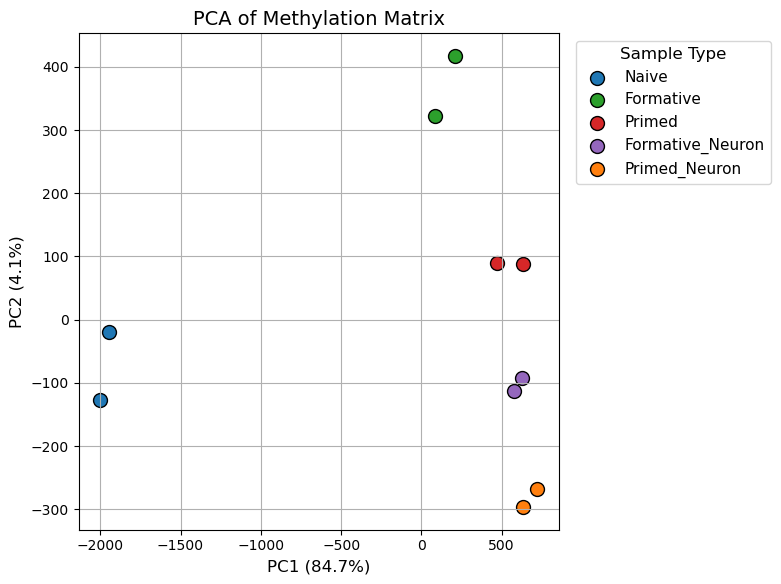

In [9]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Extract sample columns
# Assuming sample columns end in "_frac"
frac_cols = [col for col in df.columns if col.endswith('_frac')]

# Transpose so samples are rows
meth_matrix = df[frac_cols].T

# Set column names to CpG row indices for clarity
meth_matrix.columns = df['CpG_ID'] if 'CpG_ID' in df.columns else range(df.shape[0])

# Drop rows with NaN 
meth_matrix_clean = meth_matrix.dropna(axis=1)

# 4. Run PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(meth_matrix_clean)

# Sample names and sample type mapping
sample_names = [name.replace('_frac', '') for name in meth_matrix_clean.index]

# Define sample type mapping and colors
def get_sample_type(name):
    if 'Formative_Neuron' in name:
        return 'Formative_Neuron'
    elif 'Primed_Neuron' in name:
        return 'Primed_Neuron'
    elif 'Naive' in name:
        return 'Naive'
    elif 'Formative' in name:
        return 'Formative'
    elif 'Primed' in name:
        return 'Primed'
    else:
        return 'Other'

sample_types = [get_sample_type(name) for name in sample_names]

palette = {
    'Naive': '#1f77b4',
    'Formative': '#2ca02c',
    'Primed': '#d62728',
    'Formative_Neuron': '#9467bd',
    'Primed_Neuron': '#ff7f0e'
}

plt.rcParams.update({ 
    'font.size': 12,           # default font size 
    'axes.titlesize': 14,      # subplot titles 
    'axes.labelsize': 12,      # x and y labels 
    'xtick.labelsize': 10,     # tick labels 
    'ytick.labelsize': 10, 
    'legend.fontsize': 11, 
    'figure.titlesize': 16     # suptitle 
})

# 8. Plot the PCA
plt.figure(figsize=(8,6))
for sample_type in palette:
    idxs = [i for i, t in enumerate(sample_types) if t == sample_type]
    plt.scatter(X_pca[idxs, 0], X_pca[idxs, 1],
                label=sample_type,
                color=palette[sample_type],
                s=100, edgecolor='k')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA of Methylation Matrix')
plt.legend(title='Sample Type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_10_samples.svg", format='svg', bbox_inches='tight')
plt.savefig("pca_10_samples.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [10]:
print(df.head(20))

    Chromosome  Start   End  Naive_1_frac  Naive_1_cov  Formative_1_frac  \
0   GL000008.2    210   212         0.175        171.0             0.624   
1   GL000008.2    404   406         0.365        192.0             0.353   
2   GL000008.2    424   426         0.228        162.0             0.538   
3   GL000008.2    629   631         0.157        134.0             0.554   
4   GL000008.2    651   653           NaN          NaN             0.301   
5   GL000008.2    664   666         0.083        132.0             0.470   
6   GL000008.2    854   856           NaN          NaN               NaN   
7   GL000008.2    906   908         0.061        131.0             0.489   
8   GL000008.2   1399  1401           NaN          NaN             0.698   
9   GL000008.2   1515  1517         0.053        169.0             0.316   
10  GL000008.2   1563  1565         0.160        282.0             0.719   
11  GL000008.2   1602  1604         0.059        119.0               NaN   
12  GL000008

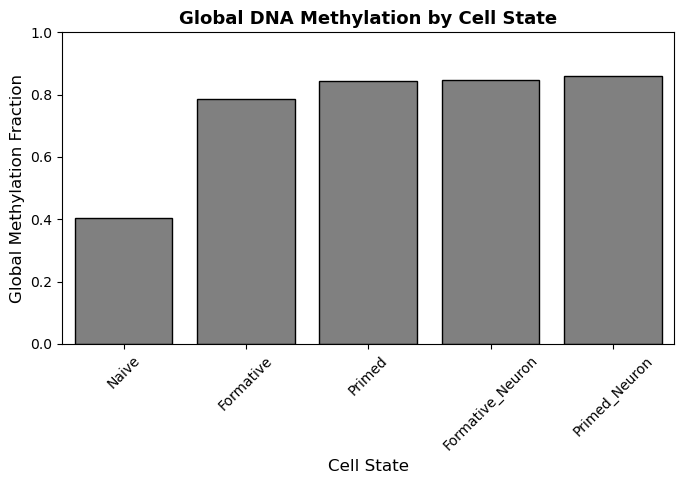

In [12]:
# Identify fraction and coverage columns
frac_cols = [col for col in df.columns if col.endswith('_frac')]
cov_cols = [col for col in df.columns if col.endswith('_cov')]

# Copy fraction dataframe to mask low coverage values
frac_df = df[frac_cols].copy()

# Mask fraction values where corresponding coverage < 10
for frac_col in frac_cols:
    cov_col = frac_col.replace('_frac', '_cov')
    low_cov_mask = df[cov_col] < 10
    frac_df.loc[low_cov_mask, frac_col] = np.nan

# Calculate mean methylation per sample, skipping NaNs
sample_means = frac_df.mean(skipna=True)

# Map sample names to cell states
def get_cell_state(name):
    if 'Formative_Neuron' in name:
        return 'Formative_Neuron'
    elif 'Primed_Neuron' in name:
        return 'Primed_Neuron'
    elif 'Formative' in name:
        return 'Formative'
    elif 'Primed' in name:
        return 'Primed'
    elif 'Naive' in name:
        return 'Naive'
    else:
        return 'Other'

cell_state_map = {col: get_cell_state(col) for col in frac_cols}

# Build dataframe of sample means with cell state info
mean_df = sample_means.to_frame(name='mean_methylation')
mean_df['cell_state'] = mean_df.index.map(cell_state_map)

# Group by cell state and calculate mean methylation
global_means = mean_df.groupby('cell_state')['mean_methylation'].mean().reset_index()

# Define order for plotting
cell_state_order = ['Naive', 'Formative', 'Primed', 'Formative_Neuron', 'Primed_Neuron']
global_means['cell_state'] = pd.Categorical(global_means['cell_state'], categories=cell_state_order, ordered=True)
global_means = global_means.sort_values('cell_state')

# Plotting style
plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

# Plot barplot
plt.figure(figsize=(7, 5))
sns.barplot(data=global_means, x='cell_state', y='mean_methylation', color='gray', edgecolor='black')
plt.ylabel('Global Methylation Fraction')
plt.xlabel('Cell State')
plt.ylim(0, 1)
plt.title('Global DNA Methylation by Cell State', fontsize=13, weight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("global_methylation_by_cell_state.pdf", bbox_inches='tight')
plt.savefig("global_methylation_by_cell_state.svg", bbox_inches='tight')
plt.show()

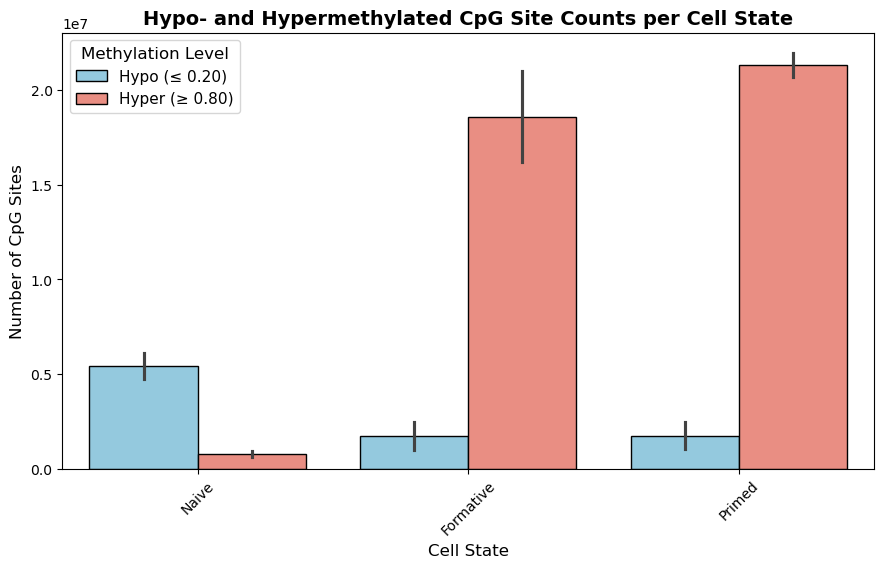

In [18]:
# Step 1: Identify columns
cov_cols = [col for col in df.columns if col.endswith('_cov')]
frac_cols = [col.replace('_cov', '_frac') for col in cov_cols]

# Step 2: Map sample to cell state
cell_state_map = {col: col.split('_')[0] for col in frac_cols}

# Step 3: Count hypo/hyper CpGs per sample, using only CpGs with cov >= 10
hypo_counts = {}
hyper_counts = {}

for frac_col, cov_col in zip(frac_cols, cov_cols):
    valid_mask = df[cov_col] >= 10
    hypo_counts[frac_col] = (df.loc[valid_mask, frac_col] <= 0.20).sum()
    hyper_counts[frac_col] = (df.loc[valid_mask, frac_col] >= 0.80).sum()

# Step 4: Create dataframe
count_df = pd.DataFrame({
    'sample': frac_cols,
    'cell_state': [cell_state_map[col] for col in frac_cols],
    'hypo_count': [hypo_counts[col] for col in frac_cols],
    'hyper_count': [hyper_counts[col] for col in frac_cols]
})

# Step 5: Melt for plotting
melted = pd.melt(count_df,
                 id_vars=['sample', 'cell_state'],
                 value_vars=['hypo_count', 'hyper_count'],
                 var_name='methylation_level',
                 value_name='CpG_count')

melted['methylation_level'] = melted['methylation_level'].map({
    'hypo_count': 'Hypo (≤ 0.20)',
    'hyper_count': 'Hyper (≥ 0.80)'
})

# Plotting style
plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

# Step 6: Plot
plt.figure(figsize=(9, 6))
sns.barplot(data=melted,
            x='cell_state', y='CpG_count',
            hue='methylation_level',
            palette={'Hypo (≤ 0.20)': 'skyblue', 'Hyper (≥ 0.80)': 'salmon'},
            edgecolor='black')

plt.ylabel('Number of CpG Sites')
plt.xlabel('Cell State')
plt.title('Hypo- and Hypermethylated CpG Site Counts per Cell State', fontsize=14, weight='bold')
plt.xticks(rotation=45)
plt.legend(title='Methylation Level')
plt.tight_layout()

# Save
plt.savefig("hypo_hyper_cpg_counts_by_cell_state.pdf", bbox_inches='tight')
plt.savefig("hypo_hyper_cpg_counts_by_cell_state.svg", bbox_inches='tight')
plt.show()